### Imports

In [117]:
!pip install --upgrade tensorflow
!pip3 install keras

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.12.0)
/bin/bash: -c: line 0: syntax error near unexpected token `)'
/bin/bash: -c: line 0: `pip3 install keras)'


In [0]:
# std & 3p
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import ZeroPadding2D
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

### MP1

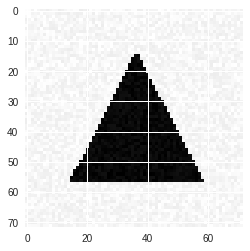

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i, "\r", end="")
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(nb_samples, free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(nb_samples, 20, free_location)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i, "\r", end="")
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]
  
def generate_dataset_denoising(nb_samples):
    # Getting im_size:
    [X_test, Y_test] = generate_dataset_classification(nb_samples, 20, True)
    Y_test = np.array(X_test > (50 / 255), dtype='int')
    return [X_test, Y_test]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def visualize_prediction2(x, y):
    f = plt.figure(figsize=(25,5))
    for j in range(len(x)):
      ax = f.add_subplot(int("1{}{}".format(len(x), j+1) ))
      I = x[j].reshape((IMAGE_SIZE,IMAGE_SIZE))
      ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
      ax.set_xlim([0,1])
      ax.set_ylim([0,1])

      xy = y[j].reshape(3,2)
      tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
      ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]





# 3 - Simple classification

### Generate dataset

In [0]:
[X_train, Y_train] = mp1.generate_dataset_classification(300, 20)
# Reformating the Desired Ouput
Y_train = to_categorical(Y_train, 3)

Creating data:


### Model 1

Creating a simple linear model with three neurones, using the cross-entropy for loss, SGD as an optimizer, softmax for output, and using cross-validation for evaluating the model

In [0]:
# Model
simple_model_1 = Sequential()
input_shape = X_train.shape[1]
simple_model_1.add(Dense(3, input_shape=(input_shape, ), activation="softmax"))
# Optimizer
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
simple_model_1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#Train
simple_model_1.fit(X_train, Y_train, validation_split=0.33, epochs=30, batch_size=32)

Train on 200 samples, validate on 100 samples
Epoch 1/30
200/200 [==============================] - 0s 509us/step - loss: 6.9562 - acc: 0.3550 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 2/30
200/200 [==============================] - 0s 59us/step - loss: 10.8797 - acc: 0.3250 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 3/30
200/200 [==============================] - 0s 50us/step - loss: 10.8797 - acc: 0.3250 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 4/30
200/200 [==============================] - 0s 61us/step - loss: 10.8797 - acc: 0.3250 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 5/30
200/200 [==============================] - 0s 49us/step - loss: 10.8797 - acc: 0.3250 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 6/30
200/200 [==============================] - 0s 57us/step - loss: 10.8797 - acc: 0.3250 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 7/30
200/200 [==============================] - 0s 48us/step - loss: 10.8797 - acc: 0.3250 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 8/3

The performance is not good using an SGD optimizer with the default parameters and 30 epochs, lets switch to an Adam optimizer who is know to be more performant that simple SGD.

### Model 2

In [0]:
# Model
simple_model_2 = Sequential()
input_shape = X_train.shape[1]
simple_model_2.add(Dense(3, input_shape=(input_shape, ), activation="softmax"))
# Optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
simple_model_2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#Train
simple_model_2.fit(X_train, Y_train, validation_split=0.33, epochs=30, batch_size=32)

Train on 200 samples, validate on 100 samples
Epoch 1/30
200/200 [==============================] - 0s 687us/step - loss: 2.1833 - acc: 0.4200 - val_loss: 2.3310 - val_acc: 0.3100
Epoch 2/30
200/200 [==============================] - 0s 55us/step - loss: 1.4944 - acc: 0.4700 - val_loss: 0.9719 - val_acc: 0.6800
Epoch 3/30
200/200 [==============================] - 0s 50us/step - loss: 0.9303 - acc: 0.6350 - val_loss: 0.7068 - val_acc: 0.6800
Epoch 4/30
200/200 [==============================] - 0s 58us/step - loss: 0.9982 - acc: 0.7000 - val_loss: 0.6214 - val_acc: 0.8200
Epoch 5/30
200/200 [==============================] - 0s 61us/step - loss: 0.6475 - acc: 0.8050 - val_loss: 0.5023 - val_acc: 0.7800
Epoch 6/30
200/200 [==============================] - 0s 62us/step - loss: 0.3853 - acc: 0.8600 - val_loss: 0.3942 - val_acc: 0.8400
Epoch 7/30
200/200 [==============================] - 0s 58us/step - loss: 0.3289 - acc: 0.8950 - val_loss: 0.3579 - val_acc: 0.8700
Epoch 8/30
200/200 [==

We can see that we achieved a validation accuracy = 100% just by using the adam optimizer. Let's now mesure the performance on a test set.

### Evaluate Model 2

In [0]:
[X_test, Y_test] = mp1.generate_dataset_classification(100, 20)
Y_test = to_categorical(Y_test, 3)

Creating data:


In [0]:
loss_and_metrics = simple_model_2.evaluate(X_test, Y_test)
print(loss_and_metrics)

100/100 [==============================] - 0s 33us/step
[0.08961169004440307, 1.0]


We have achieved a 100% accuracy on the test dataset!!

# 4 - Visualization of the Solution

In [0]:
simple_model_2.get_weights()[0].shape

(5184, 3)

In [0]:
simple_model_2.get_weights()[1]

array([ 2.0516978e-03, -4.5390079e-05, -6.7257177e-04], dtype=float32)

Text(0.5, 1.0, 'Triangle')

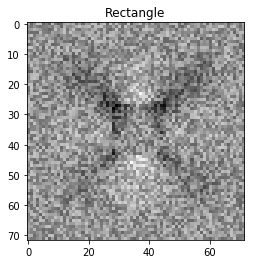

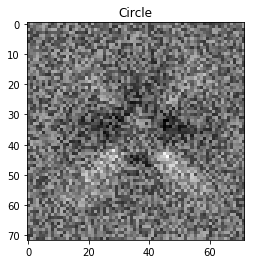

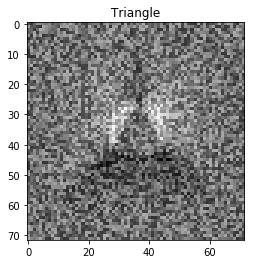

In [0]:
W, _ = simple_model_2.get_weights()

plt.figure(1)
plt.imshow(W[:,0].reshape(72,72), cmap='gray')
plt.title('Rectangle')

plt.figure(2)
plt.imshow(W[:,1].reshape(72,72), cmap='gray')
plt.title('Circle')

plt.figure(3)
plt.imshow(W[:,2].reshape(72,72), cmap='gray')
plt.title('Triangle')

We can see that each column is detecting a shape.

# 5 - A More Difficult Classification Problem

### Generate dataset

In [0]:
n_samples = 1000
[X_train, Y_train] = mp1.generate_dataset_classification(n_samples, 20, True)
Y_train = to_categorical(Y_train, 3)
[X_test, Y_test] = mp1.generate_test_set_classification(n_samples, True)
Y_test = to_categorical(Y_test, 3)

Creating data:
Creating data:


In [0]:
# Model
simple_model_2 = Sequential()
input_shape = X_train.shape[1]
simple_model_2.add(Dense(3, input_shape=(input_shape, ), activation="softmax"))
# Optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
simple_model_2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#Train
simple_model_2.fit(X_train, Y_train, validation_split=0.33, epochs=40, batch_size=32)

Train on 200 samples, validate on 100 samples
Epoch 1/40
200/200 [==============================] - 0s 470us/step - loss: 3.0216 - acc: 0.3200 - val_loss: 3.9350 - val_acc: 0.2700
Epoch 2/40
200/200 [==============================] - 0s 56us/step - loss: 2.2171 - acc: 0.3450 - val_loss: 2.3944 - val_acc: 0.3200
Epoch 3/40
200/200 [==============================] - 0s 59us/step - loss: 1.8032 - acc: 0.4150 - val_loss: 1.9651 - val_acc: 0.4300
Epoch 4/40
200/200 [==============================] - 0s 61us/step - loss: 1.4667 - acc: 0.3700 - val_loss: 1.2889 - val_acc: 0.3700
Epoch 5/40
200/200 [==============================] - 0s 59us/step - loss: 1.2409 - acc: 0.4250 - val_loss: 1.3814 - val_acc: 0.3900
Epoch 6/40
200/200 [==============================] - 0s 60us/step - loss: 1.3302 - acc: 0.4350 - val_loss: 1.5126 - val_acc: 0.4200
Epoch 7/40
200/200 [==============================] - 0s 57us/step - loss: 1.2807 - acc: 0.4000 - val_loss: 1.0316 - val_acc: 0.4100
Epoch 8/40
200/200 [==

We can see that with the same architecture, we do not obtain the same performances as before, even if we try the tuning of the hyperparameters.

### CNN Model

In [0]:
X_train2 = X_train.reshape(n_samples,72,72,1)
X_test2 = X_test.reshape(n_samples,72,72,1)

In [0]:
# Model
cnn_model = Sequential()
cnn_model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(124, activation='relu'))
cnn_model.add(Dense(3, activation='softmax'))
# Optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#Train
cnn_model.fit(X_train2, Y_train, validation_split=0.33, epochs=40, batch_size=32)

Train on 669 samples, validate on 331 samples
Epoch 1/40
669/669 [==============================] - 1s 2ms/step - loss: 1.3966 - acc: 0.4096 - val_loss: 0.8603 - val_acc: 0.6254
Epoch 2/40
669/669 [==============================] - 1s 2ms/step - loss: 0.7209 - acc: 0.7040 - val_loss: 0.7098 - val_acc: 0.7130
Epoch 3/40
669/669 [==============================] - 1s 2ms/step - loss: 0.5770 - acc: 0.7773 - val_loss: 0.6718 - val_acc: 0.7160
Epoch 4/40
669/669 [==============================] - 1s 2ms/step - loss: 0.4608 - acc: 0.8670 - val_loss: 0.6057 - val_acc: 0.7674
Epoch 5/40
669/669 [==============================] - 1s 2ms/step - loss: 0.3829 - acc: 0.8819 - val_loss: 0.5921 - val_acc: 0.7764
Epoch 6/40
669/669 [==============================] - 1s 2ms/step - loss: 0.3536 - acc: 0.8969 - val_loss: 0.5552 - val_acc: 0.7915
Epoch 7/40
669/669 [==============================] - 1s 2ms/step - loss: 0.2699 - acc: 0.9357 - val_loss: 0.5449 - val_acc: 0.7704
Epoch 8/40
669/669 [==========

In [0]:
loss_and_metrics = cnn_model.evaluate(X_test2, Y_test)
print(loss_and_metrics)

1000/1000 [==============================] - 0s 481us/step
[0.5344937982559204, 0.843]


We obtain a performance of 84% on the test dataset, which is better than the old model. This performance can be increased by increasing the number of batches, and by making the model more complex by adding more layers and using dropout, for example.

# 6 - A Regression Problem

### Generate dataset

In [4]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
Creating data:


### Visualize data

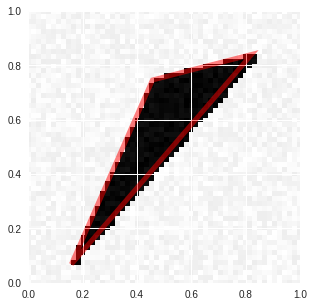

In [5]:
visualize_prediction(X_test[100], Y_test[100])

### Normalize data

We tried to train the model using the following architecture, but we obtained poor results, this is explained by the fact that the algorithm tries to predict the three vertices of the triangles that are in any order, which is difficult. To remedy this, we tried to sort the different vertices by their x coordinate.

In [0]:
X_train2 = X_train.reshape(-1,72,72,1)
X_test2 = X_test.reshape(-1,72,72,1)

In [0]:
# Sorting function
def sorting_vertices(vertices):
    chunks = vertices[0::2]
    order = chunks.argsort()
    return np.array([(vertices[i*2], vertices[i*2+1])for i in order]).flatten()

In [0]:
Y_train2 = np.apply_along_axis(sorting_vertices, 1, Y_train)

In [15]:
# Verification
print(Y_train[0])
print(Y_train2[0])

[0.2933456  0.63116809 0.72574115 0.55528757 0.62126663 0.293224  ]
[0.2933456  0.63116809 0.62126663 0.293224   0.72574115 0.55528757]


### Regression model

We created a model composed of three successive layers of Conv2D and MaxPooling2D, followed by a dense layer that predicts the positions of the three vertices. We use mean squared error as loss function, and we use an "adam optimizer" with a learning rate equal to 0.0001.

In [44]:
# Model
reg_model = Sequential()
reg_model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(72, 72, 1), kernel_regularizer=l2(0.00001)))
reg_model.add(MaxPooling2D(pool_size=(2, 2)))
reg_model.add(Conv2D(64, (3, 3), activation='relu'))
reg_model.add(MaxPooling2D(pool_size=(5, 5)))
reg_model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(72, 72, 1)))
reg_model.add(MaxPooling2D(pool_size=(2, 2)))
reg_model.add(Flatten())
reg_model.add(Dense(6))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
reg_model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
reg_model.fit(X_train2, Y_train2, epochs=300, batch_size=32, validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/300
2700/2700 [==============================] - 3s 1ms/step - loss: 0.0995 - mean_squared_error: 0.0995 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 2/300
2700/2700 [==============================] - 2s 906us/step - loss: 0.0481 - mean_squared_error: 0.0480 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 3/300
2700/2700 [==============================] - 2s 915us/step - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 4/300
2700/2700 [==============================] - 2s 906us/step - loss: 0.0279 - mean_squared_error: 0.0278 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 5/300
2700/2700 [==============================] - 2s 907us/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0237 - val_mean_squared_error: 0.0236
Epoch 6/300
2700/2700 [==============================] - 2s 903us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val

### Test model
It can be seen that the model arrives in a large number of cases of detecting the location of the triangle, but it does not succeed in accurately detecting the position of the different vertices.

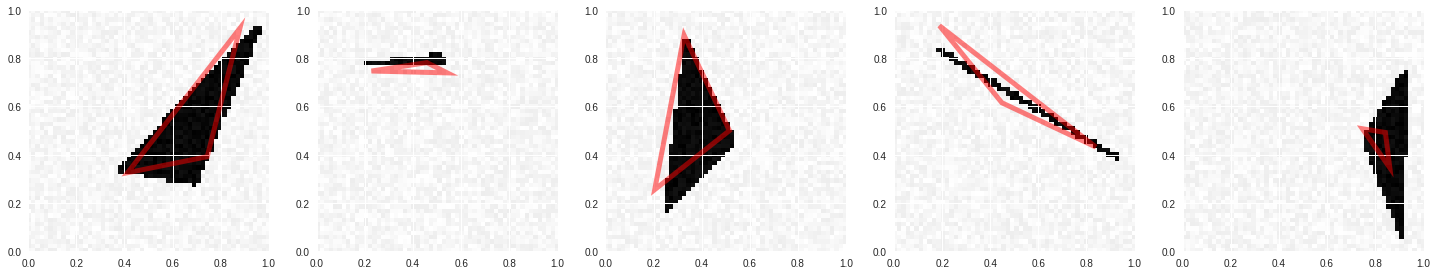

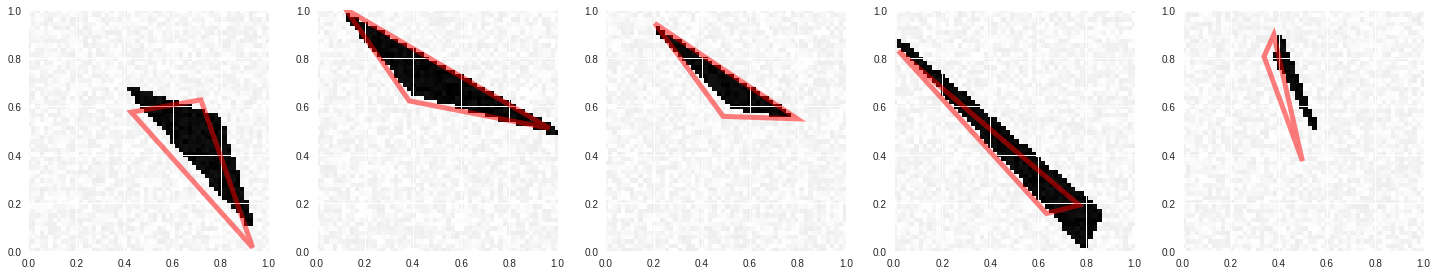

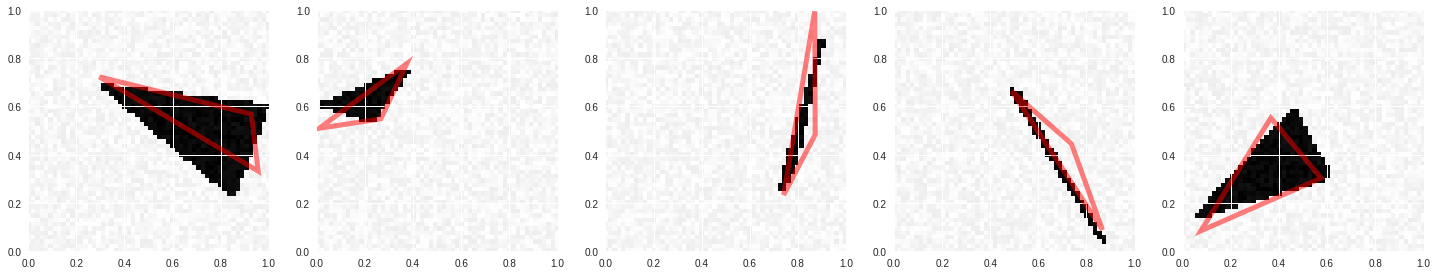

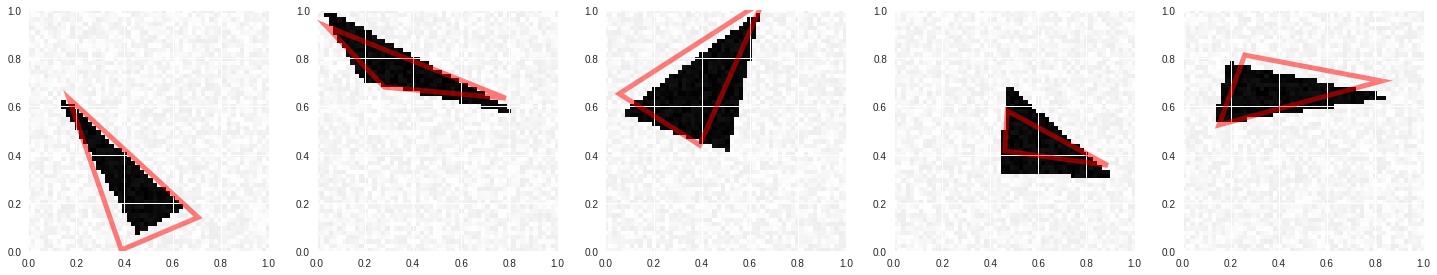

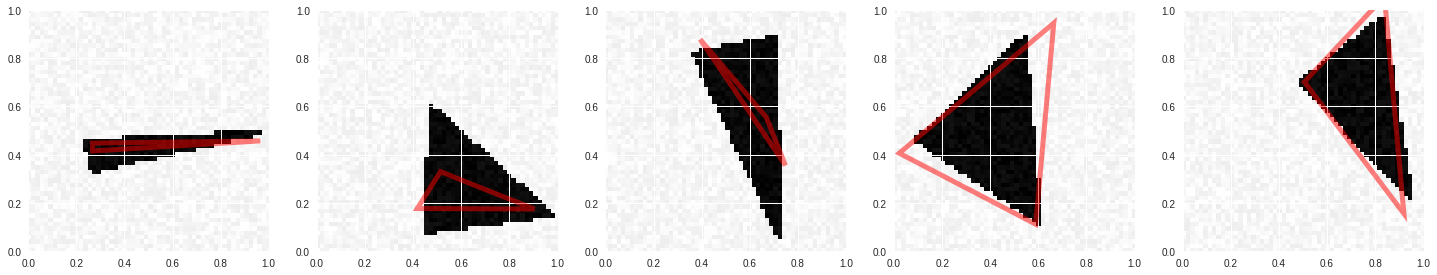

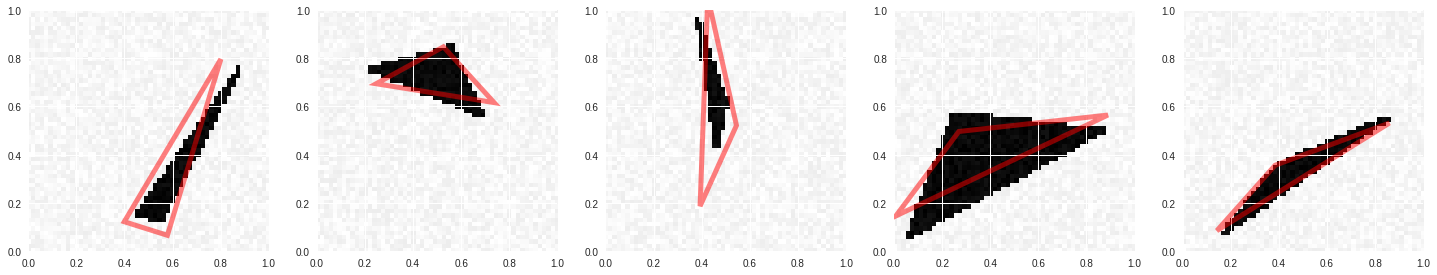

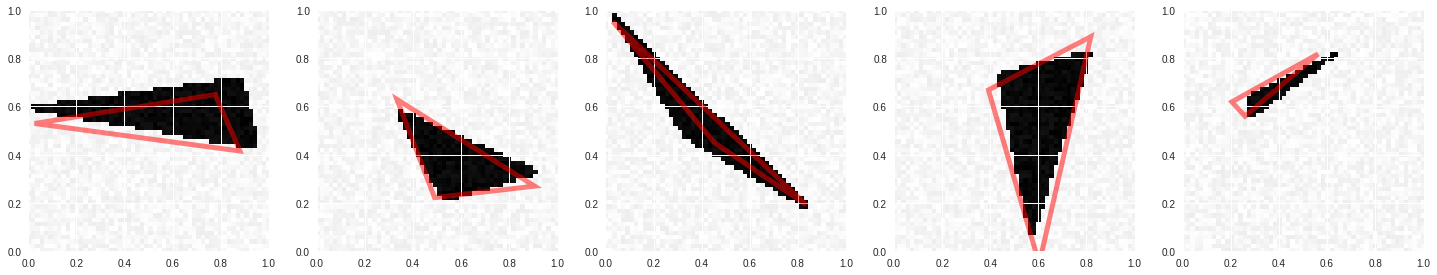

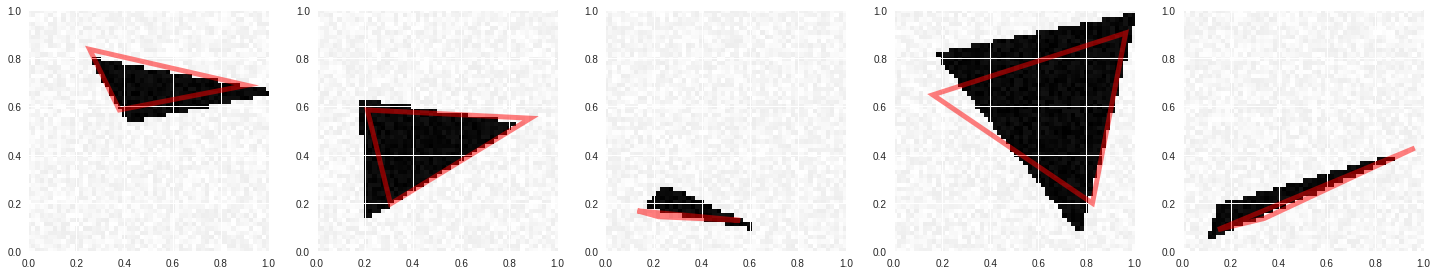

In [46]:
predictions = reg_model.predict(X_test2)
for i in range(0,40,5):
    visualize_prediction2(X_test[i:i+5], predictions[i:i+5])

# 7 - Image Denoising

### Generate dataset

We have created a function in *mp1.py * to generate training data for the denoising model.

In [91]:
[X_train, Y_train] = generate_dataset_denoising(2000)
[X_test, Y_test] = generate_dataset_denoising(200)

Creating data:
Creating data:


In [0]:
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)
Y_train = Y_train.reshape(-1,72,72,1)
Y_test = Y_test.reshape(-1,72,72,1)

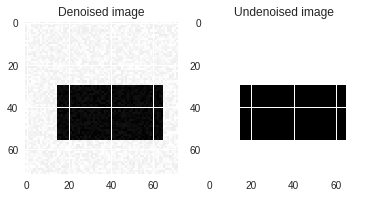

In [119]:
id = 11
plt.subplot(121)
plt.imshow(X_train[id].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Denoised image")
plt.subplot(122)
plt.imshow(Y_train[id].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Undenoised image")
plt.show()

### Denoising model
We have implemented denoising model, that consist on a autoencoder composed of successive Conv2D and batch normalization layers and the task is treated as a segmentation task. The model is trained on 2000 samples and 20 epochs using "adam optimizer".

In [0]:
den_model =Sequential()

den_model.add(Convolution2D(60,kernel_size=(3,3),input_shape=(72,72,1,),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(MaxPooling2D(pool_size=(2,2)))
den_model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(Convolution2D(40,kernel_size=(2,2),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(MaxPooling2D(pool_size=(2,2)))
den_model.add(Convolution2D(60,kernel_size=(3,3),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(UpSampling2D(size=(2,2)))
den_model.add(Convolution2D(40,kernel_size=(3,3),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(Convolution2D(20,kernel_size=(2,2),padding='same'))
den_model.add(BatchNormalization())
den_model.add(Activation('relu'))
den_model.add(UpSampling2D(size=(2,2)))
den_model.add(ZeroPadding2D(padding=(1, 1)))
den_model.add(Convolution2D(1,kernel_size=(3,3)))
den_model.add(Dense(1,activation='sigmoid'))
den_model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [101]:
den_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.1)

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0177 - acc: 0.9985 - val_loss: 0.0174 - val_acc: 0.9967
Epoch 2/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0117 - acc: 0.9987 - val_loss: 0.0109 - val_acc: 0.9984
Epoch 3/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0085 - acc: 0.9989 - val_loss: 0.0081 - val_acc: 0.9984
Epoch 4/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0063 - acc: 0.9992 - val_loss: 0.0060 - val_acc: 0.9990
Epoch 5/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0050 - acc: 0.9994 - val_loss: 0.0047 - val_acc: 0.9992
Epoch 6/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0041 - acc: 0.9995 - val_loss: 0.0040 - val_acc: 0.9993
Epoch 7/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0037 - val_acc: 0.9992
Epoch 8/20
1800

### Test model 
We notice that this architecture converges quickly, and gives good results (99.9% accuracy).

In [0]:
predictions = den_model.predict(X_test)

In [122]:
loss_and_metrics = den_model.evaluate(X_test, Y_test)
print("Accuracy: {}%".format(round(loss_and_metrics[1] * 100, 2)))

200/200 [==============================] - 0s 1ms/step
Accuracy: 99.98%


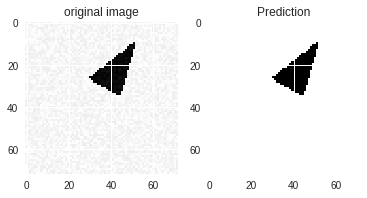

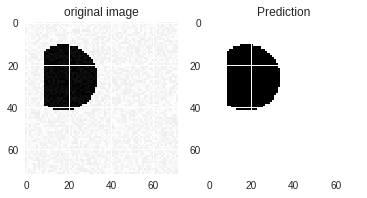

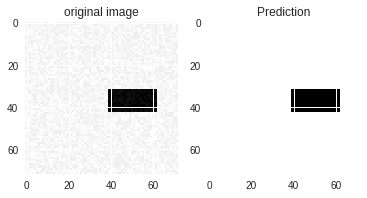

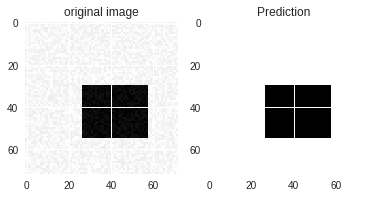

In [120]:
for id in range(4):
  plt.subplot(121)
  plt.imshow(X_train[id].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  plt.title("original image")
  plt.subplot(122)
  plt.imshow(Y_train[id].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  plt.title("Prediction")
  plt.show()